In [19]:
# Data Preprocessing


import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Loading bank-full dataset
file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\bank-full.csv"
data = pd.read_csv(file_path, sep=";")  # creates dataframe

# Display the first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Label encode binary columns
binary_cols = ['default', 'housing', 'loan', 'y']
le = LabelEncoder()   # Transforms these binary columns to numerical data
for col in binary_cols:
    data[col] = le.fit_transform(data[col])

# One-hot encode categorical columns
data = pd.get_dummies(data, columns=['job', 'marital', 'education', 'contact', 'month', 'poutcome'])
data = data.astype(int)

data = data.drop(columns=['duration'])

# Create the 'was_contacted' column [0 means not contacted, 1 means contacted]
data['was_contacted'] = (data['pdays'] != -1).astype(int)

# Replace -1 in 'pdays' with NaN
data['pdays'] = data['pdays'].replace(-1, np.nan)

# Change NaN values to mean for normalization
data['pdays'] = data['pdays'].fillna(data['pdays'].mean())

# Remove outlier from previous column manually
data = data[data['previous'] != 275]


# Save the preprocessed data
preprocessed_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_preprocessed1.csv"
data.to_csv(preprocessed_file_path, index=False)
print(f"Preprocessed data saved to {preprocessed_file_path}")



   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan  

In [21]:
# Feature Engineering


import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Load the preprocessed data
preprocessed_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_preprocessed2.csv"
data = pd.read_csv(preprocessed_file_path)


numeric_cols = ['age', 'pdays', 'previous', 'balance', 'campaign', 'day']


# Scale numeric features
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Applying PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(data[numeric_cols])

# Create a new DataFrame for PCA-transformed features
pca_columns = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
pca_data = pd.DataFrame(X_pca, columns=pca_columns)

# Combining PCA data with other columns except numeric_cols
final_data = pd.concat([pca_data, data.drop(columns=numeric_cols)], axis=1)

# Handling missing values in the target variable
final_data['y'] = final_data['y'].fillna(final_data['y'].mode()[0])  # Fill NaNs with the mode

# Save the finalized dataset
finalized_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_finalized1.csv"
final_data.to_csv(finalized_file_path, index=False)
print(f"Finalized data saved to {finalized_file_path}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

Finalized data saved to C:\Users\Muralish\Desktop\Machine lerning coursework\Data\bank\preprocessed_bankdata\bank-full\bank_finalized2.csv
Explained Variance Ratio: [0.19817233 0.18942328 0.16492939 0.15931463 0.15081204 0.13734833]


In [22]:
# No smote and no tuning

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# from FeatureEngineering import final_data, pca

# Save the finalized dataset
finalized_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_finalized1.csv"
final_data.to_csv(finalized_file_path, index=False)
print(f"Finalized data saved to {finalized_file_path}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

# Preparing data for modeling
X = final_data.drop(columns=['y'])
y = final_data['y']

# Splitting the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# --- Random Forest Model (Without Hyperparameter Tuning) ---
rf_model = RandomForestClassifier(random_state=42)

# Fitting the Random Forest model
rf_model.fit(X_train, y_train)

# Predicting probabilities for the training and test sets
y_pred_rf_train_prob = rf_model.predict_proba(X_train)[:, 1]
y_pred_rf_test_prob = rf_model.predict_proba(X_test)[:, 1]

# Applying thresholding for class imbalance
threshold = 0.3  # Adjust this threshold based on desired precision/recall tradeoff
y_pred_rf_train = (y_pred_rf_train_prob >= threshold).astype(int)
y_pred_rf_test = (y_pred_rf_test_prob >= threshold).astype(int)

# Evaluating Random Forest (Training)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
print("\nRandom Forest Model Evaluation (Training):")
print(f"Training Accuracy: {accuracy_rf_train * 100:.2f}%")

# Evaluating Random Forest (Testing)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
roc_auc_rf_test = roc_auc_score(y_test, y_pred_rf_test_prob)

print("\nRandom Forest Model Evaluation (Without Hyperparameter Tuning):")
print(f"Test Accuracy: {accuracy_rf_test * 100:.2f}%")
print(f"Test ROC AUC: {roc_auc_rf_test:.2f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_rf_test, zero_division=0))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_rf_test))

# --- Neural Network Model (Without Hyperparameter Tuning) ---
# Building a neural network model using Keras
nn_model = Sequential()
nn_model.add(Input(shape=(X_train.shape[1],)))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

# Compiling the model
nn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Training the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_model.fit(X_train, y_train, epochs=75, batch_size=32, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predicting probabilities for the training and test sets
y_pred_nn_train_prob = nn_model.predict(X_train)
y_pred_nn_test_prob = nn_model.predict(X_test)

# Applying thresholding
y_pred_nn_train = (y_pred_nn_train_prob >= threshold).astype(int)
y_pred_nn_test = (y_pred_nn_test_prob >= threshold).astype(int)

# Evaluating Neural Network (Training)
accuracy_nn_train = accuracy_score(y_train, y_pred_nn_train)
print("\nNeural Network Model Evaluation (Training):")
print(f"Training Accuracy: {accuracy_nn_train * 100:.2f}%")

# Evaluating Neural Network (Testing)
accuracy_nn_test = accuracy_score(y_test, y_pred_nn_test)
roc_auc_nn_test = roc_auc_score(y_test, y_pred_nn_test_prob)

print("\nNeural Network Model Evaluation (Without Hyperparameter Tuning):")
print(f"Test Accuracy: {accuracy_nn_test * 100:.2f}%")
print(f"Test ROC AUC: {roc_auc_nn_test:.2f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_nn_test, zero_division=0))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_nn_test))


Finalized data saved to C:\Users\Muralish\Desktop\Machine lerning coursework\Data\bank\preprocessed_bankdata\bank-full\bank_finalized2.csv
Explained Variance Ratio: [0.19817233 0.18942328 0.16492939 0.15931463 0.15081204 0.13734833]

Random Forest Model Evaluation (Training):
Training Accuracy: 99.85%

Random Forest Model Evaluation (Without Hyperparameter Tuning):
Test Accuracy: 88.17%
Test ROC AUC: 0.79

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      5988
           1       0.49      0.45      0.47       794

    accuracy                           0.88      6782
   macro avg       0.71      0.69      0.70      6782
weighted avg       0.88      0.88      0.88      6782


Confusion Matrix (Test):
[[5625  363]
 [ 439  355]]
Epoch 1/75
989/989 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8818 - loss: 0.3302 - val_accuracy: 0.8951 - val_loss: 0.2971
Epoch 2/75
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step 

In [24]:
# No smote with tuning


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV

# from FeatureEngineering import final_data, pca

# Save the finalized dataset

finalized_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_finalized1.csv"
final_data.to_csv(finalized_file_path, index=False)
print(f"Finalized data saved to {finalized_file_path}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

# Preparing data for modeling
X = final_data.drop(columns=['y'])
y = final_data['y']

# Splitting the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# --- Hyperparameter Tuning for Random Forest ---
rf_model = RandomForestClassifier(random_state=42)

# Define parameter grid for RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', 0.1, 0.3, 0.5],
    'max_samples': [0.8, 0.9, 1.0],
    'bootstrap': [True],
    'oob_score': [True, False],
    'class_weight': [None, 'balanced'],
    'warm_start': [True, False],
    'random_state': [42]
}

# Performing RandomizedSearchCV (performs hyperparameter tuning)
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, n_iter=10, cv=3, random_state=42, verbose=2, n_jobs=-1)
rf_random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_rf_model = rf_random_search.best_estimator_

# Predicting probabilities for the training and test sets
y_pred_rf_train_prob = best_rf_model.predict_proba(X_train)[:, 1]
y_pred_rf_test_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Applying thresholding for class imbalance
threshold = 0.3  # Adjust this threshold based on desired precision/recall tradeoff
y_pred_rf_train = (y_pred_rf_train_prob >= threshold).astype(int)
y_pred_rf_test = (y_pred_rf_test_prob >= threshold).astype(int)

# Evaluating Random Forest (Training)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
print("\nRandom Forest Model Evaluation (Training):")
print(f"Training Accuracy: {accuracy_rf_train * 100:.2f}%")

# Evaluating Random Forest (Testing)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
roc_auc_rf_test = roc_auc_score(y_test, y_pred_rf_test_prob)

print("\nRandom Forest Model Evaluation (Tuned with Threshold):")
print(f"Test Accuracy: {accuracy_rf_test * 100:.2f}%")
print(f"Test ROC AUC: {roc_auc_rf_test:.2f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_rf_test, zero_division=0))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_rf_test))

# --- Neural Network Model ---
# Building a neural network model using Keras
nn_model = Sequential()
nn_model.add(Input(shape=(X_train.shape[1],)))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

# Compiling the model
nn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Training the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

nn_model.fit(X_train, y_train, epochs=75, batch_size=32, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predicting probabilities for the training and test sets
y_pred_nn_train_prob = nn_model.predict(X_train)
y_pred_nn_test_prob = nn_model.predict(X_test)

# Applying thresholding
y_pred_nn_train = (y_pred_nn_train_prob >= threshold).astype(int)
y_pred_nn_test = (y_pred_nn_test_prob >= threshold).astype(int)

# Evaluating Neural Network (Training)
accuracy_nn_train = accuracy_score(y_train, y_pred_nn_train)
print("\nNeural Network Model Evaluation (Training):")
print(f"Training Accuracy: {accuracy_nn_train * 100:.2f}%")

# Evaluating Neural Network (Testing)
accuracy_nn_test = accuracy_score(y_test, y_pred_nn_test)
roc_auc_nn_test = roc_auc_score(y_test, y_pred_nn_test_prob)

print("\nNeural Network Model Evaluation (Tuned with Threshold):")
print(f"Test Accuracy: {accuracy_nn_test * 100:.2f}%")
print(f"Test ROC AUC: {roc_auc_nn_test:.2f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_nn_test, zero_division=0))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_nn_test))




Finalized data saved to C:\Users\Muralish\Desktop\Machine lerning coursework\Data\bank\preprocessed_bankdata\bank-full\bank_finalized2.csv
Explained Variance Ratio: [0.19817233 0.18942328 0.16492939 0.15931463 0.15081204 0.13734833]
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Random Forest Model Evaluation (Training):
Training Accuracy: 93.42%

Random Forest Model Evaluation (Tuned with Threshold):
Test Accuracy: 88.81%
Test ROC AUC: 0.79

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5988
           1       0.53      0.42      0.47       794

    accuracy                           0.89      6782
   macro avg       0.73      0.69      0.70      6782
weighted avg       0.88      0.89      0.88      6782


Confusion Matrix (Test):
[[5686  302]
 [ 457  337]]
Epoch 1/75
989/989 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8791 - loss: 0.3354 - val_accuracy: 0.8940 - val_loss: 0.2957


In [25]:
#With smote no tuning Random Forest

# RF model Using smote and no hyperparameter tuning

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Loading the preprocessed data
preprocessed_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_preprocessed1.csv"
data = pd.read_csv(preprocessed_file_path)


# Define numerical columns
numeric_cols = ['age', 'pdays', 'previous', 'balance', 'campaign', 'day']

# Split data into features (X) and target (y)
X = data.drop(columns=['y'])
y = data['y']

# --- Apply SMOTE for oversampling before scaling ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# --- Scale only numerical features ---
# Extract numerical columns for scaling
X_numerical = X_resampled[numeric_cols]

# Scale the numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_numerical_scaled)

# Create a new DataFrame for PCA-transformed features
pca_columns = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
pca_data = pd.DataFrame(X_pca, columns=pca_columns)

# --- Combine PCA data with other columns (except numerical columns) ---
# Keep non-numeric features (categorical and others)
X_non_numerical = X_resampled.drop(columns=numeric_cols)

# Concatenate PCA data with non-numerical features
final_data = pd.concat([pca_data, X_non_numerical], axis=1)

# Add the target variable 'y' back into the final_data
final_data['y'] = y_resampled

# Handle missing values in the target variable
final_data['y'] = final_data['y'].fillna(final_data['y'].mode()[0])  # Fill NaNs with the mode

# Save the finalized dataset
finalized_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_finalized2.csv"
final_data.to_csv(finalized_file_path, index=False)
print(f"Finalized data saved to {finalized_file_path}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

# Prepare data for modeling
X = final_data.drop(columns=['y'])
y = final_data['y']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_resampled, test_size=0.3, random_state=42, stratify=y)

# --- Random Forest Model ---
rf_model = RandomForestClassifier(random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Predict probabilities for the training and test sets
y_pred_rf_train_prob = rf_model.predict_proba(X_train)[:, 1]
y_pred_rf_test_prob = rf_model.predict_proba(X_test)[:, 1]

# Convert probabilities to class labels
y_pred_rf_train = (y_pred_rf_train_prob >= 0.5).astype(int)
y_pred_rf_test = (y_pred_rf_test_prob >= 0.5).astype(int)

# Evaluate Random Forest (Training)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
print("\nRandom Forest Model Evaluation (Training):")
print(f"Training Accuracy: {accuracy_rf_train * 100:.2f}%")

# Evaluate Random Forest (Testing)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
roc_auc_rf_test = roc_auc_score(y_test, y_pred_rf_test_prob)

print("\nRandom Forest Model Evaluation (Test):")
print(f"Test Accuracy: {accuracy_rf_test * 100:.2f}%")
print(f"Test ROC AUC: {roc_auc_rf_test:.2f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_rf_test, zero_division=0))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_rf_test))


Finalized data saved to C:\Users\Muralish\Desktop\Machine lerning coursework\Data\bank\preprocessed_bankdata\bank-full\bank_finalized2.csv
Explained Variance Ratio: [0.20648913 0.18787702 0.17104625 0.14948675 0.14574621 0.13935465]

Random Forest Model Evaluation (Training):
Training Accuracy: 100.00%

Random Forest Model Evaluation (Test):
Test Accuracy: 93.48%
Test ROC AUC: 0.97

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     11977
           1       0.96      0.90      0.93     11976

    accuracy                           0.93     23953
   macro avg       0.94      0.93      0.93     23953
weighted avg       0.94      0.93      0.93     23953


Confusion Matrix (Test):
[[11581   396]
 [ 1166 10810]]


In [26]:
# Neural Network Using smote and no hyperparameter tuning

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

# Loading the preprocessed data
preprocessed_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_preprocessed1.csv"
data = pd.read_csv(preprocessed_file_path)


# Define numerical columns
numeric_cols = ['age', 'pdays', 'previous', 'balance', 'campaign', 'day']

# Split data into features (X) and target (y)
X = data.drop(columns=['y'])
y = data['y']

# Apply SMOTE for oversampling before scaling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Scale only numerical features
X_numerical = X_resampled[numeric_cols]
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_numerical_scaled)

# Create a new DataFrame for PCA-transformed features
pca_columns = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
pca_data = pd.DataFrame(X_pca, columns=pca_columns)

# Combine PCA data with other columns (except numerical columns)
X_non_numerical = X_resampled.drop(columns=numeric_cols)
final_data = pd.concat([pca_data, X_non_numerical], axis=1)

# Add the target variable 'y' back into the final_data
final_data['y'] = y_resampled

# Prepare data for modeling
X = final_data.drop(columns=['y'])
y = final_data['y']

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Neural Network Model
nn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
nn_model.fit(X_train, y_train, epochs=75, batch_size=32, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predict probabilities for the training and test sets
y_pred_nn_train_prob = nn_model.predict(X_train)
y_pred_nn_test_prob = nn_model.predict(X_test)

# Define a threshold for classification
threshold = 0.5
y_pred_nn_train = (y_pred_nn_train_prob >= threshold).astype(int)
y_pred_nn_test = (y_pred_nn_test_prob >= threshold).astype(int)

# Evaluate Neural Network (Training)
accuracy_nn_train = accuracy_score(y_train, y_pred_nn_train)
print("\nNeural Network Model Evaluation (Training):")
print(f"Training Accuracy: {accuracy_nn_train * 100:.2f}%")

# Evaluate Neural Network (Testing)
accuracy_nn_test = accuracy_score(y_test, y_pred_nn_test)
roc_auc_nn_test = roc_auc_score(y_test, y_pred_nn_test_prob)

print("\nNeural Network Model Evaluation:")
print(f"Test Accuracy: {accuracy_nn_test * 100:.2f}%")
print(f"Test ROC AUC: {roc_auc_nn_test:.2f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_nn_test, zero_division=0))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_nn_test))


Epoch 1/75
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8833 - loss: 0.2949 - val_accuracy: 0.9355 - val_loss: 0.1879
Epoch 2/75
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9348 - loss: 0.1809 - val_accuracy: 0.9365 - val_loss: 0.1784
Epoch 3/75
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9359 - loss: 0.1783 - val_accuracy: 0.9370 - val_loss: 0.1777
Epoch 4/75
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9369 - loss: 0.1733 - val_accuracy: 0.9387 - val_loss: 0.1731
Epoch 5/75
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9385 - loss: 0.1702 - val_accuracy: 0.9341 - val_loss: 0.1842
Epoch 6/75
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9393 - loss: 0.1686 - val_accuracy: 0.9371 - val_loss: 0.1774
Epoch 7/75
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9414 - loss: 0.1596 - val_accuracy: 0.9389 - val_loss: 0.1729
Epoch 8/75
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9415 - loss: 0.1608 - 

In [27]:
# With smote and hyperparameter tuning Random Forest


import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Loading the preprocessed data
preprocessed_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_preprocessed1.csv"
data = pd.read_csv(preprocessed_file_path)


# Define numerical columns
numeric_cols = ['age', 'pdays', 'previous', 'balance', 'campaign', 'day']

# Split data into features (X) and target (y)
X = data.drop(columns=['y'])
y = data['y']

# --- Apply SMOTE for oversampling before scaling ---
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# --- Scale only numerical features ---
# Extract numerical columns for scaling
X_numerical = X_resampled[numeric_cols]

# Scale the numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_numerical_scaled)

# Create a new DataFrame for PCA-transformed features
pca_columns = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
pca_data = pd.DataFrame(X_pca, columns=pca_columns)

# --- Combine PCA data with other columns (except numerical columns) ---
# Keep non-numeric features (categorical and others)
X_non_numerical = X_resampled.drop(columns=numeric_cols)

# Concatenate PCA data with non-numerical features
final_data = pd.concat([pca_data, X_non_numerical], axis=1)

# Add the target variable 'y' back into the final_data
final_data['y'] = y_resampled

# Handle missing values in the target variable
final_data['y'] = final_data['y'].fillna(final_data['y'].mode()[0])  # Fill NaNs with the mode

# Save the finalized dataset
finalized_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_finalized3.csv"
final_data.to_csv(finalized_file_path, index=False)
print(f"Finalized data saved to {finalized_file_path}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

# Prepare data for modeling
X = final_data.drop(columns=['y'])
y = final_data['y']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_resampled, test_size=0.3, random_state=42, stratify=y)

rf_model = RandomForestClassifier(random_state=42)

# Define parameter grid for RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', 0.1, 0.3, 0.5],
    'max_samples': [0.8, 0.9, 1.0],
    'bootstrap': [True],
    'oob_score': [True, False],
    'class_weight': [None, 'balanced'],
    'warm_start': [True, False],
    'random_state': [42]
}

# Perform RandomizedSearchCV
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, n_iter=10, cv=3, random_state=42, verbose=2, n_jobs=-1)
rf_random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_rf_model = rf_random_search.best_estimator_

# Predict probabilities for the training and test sets
y_pred_rf_train_prob = best_rf_model.predict_proba(X_train)[:, 1]
y_pred_rf_test_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Apply thresholding
threshold = 0.3  # Adjust this threshold based on desired precision/recall tradeoff
y_pred_rf_train = (y_pred_rf_train_prob >= threshold).astype(int)
y_pred_rf_test = (y_pred_rf_test_prob >= threshold).astype(int)

# Evaluate Random Forest (Training)
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
print("\nRandom Forest Model Evaluation (Training):")
print(f"Training Accuracy: {accuracy_rf_train * 100:.2f}%")

# Evaluate Random Forest (Testing)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)
roc_auc_rf_test = roc_auc_score(y_test, y_pred_rf_test_prob)

print("\nRandom Forest Model Evaluation (Tuned with Threshold):")
print(f"Test Accuracy: {accuracy_rf_test * 100:.2f}%")
print(f"Test ROC AUC: {roc_auc_rf_test:.2f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_rf_test, zero_division=0))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_rf_test))

Finalized data saved to C:\Users\Muralish\Desktop\Machine lerning coursework\Data\bank\preprocessed_bankdata\bank-full\bank_finalized3.csv
Explained Variance Ratio: [0.20648913 0.18787702 0.17104625 0.14948675 0.14574621 0.13935465]
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Random Forest Model Evaluation (Training):
Training Accuracy: 95.17%

Random Forest Model Evaluation (Tuned with Threshold):
Test Accuracy: 91.25%
Test ROC AUC: 0.97

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     11977
           1       0.89      0.94      0.91     11976

    accuracy                           0.91     23953
   macro avg       0.91      0.91      0.91     23953
weighted avg       0.91      0.91      0.91     23953


Confusion Matrix (Test):
[[10628  1349]
 [  746 11230]]


In [4]:
# With smote and hyperparameter tuning Neural Network

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch  # Keras Tuner for hyperparameter tuning
from imblearn.over_sampling import SMOTE  # Import SMOTE

# Loading the preprocessed data
preprocessed_file_path = "C:\\Users\\Muralish\\Desktop\\Machine lerning coursework\\Data\\bank\\preprocessed_bankdata\\bank-full\\bank_preprocessed1.csv"
data = pd.read_csv(preprocessed_file_path)

# Define numerical columns
numeric_cols = ['age', 'pdays', 'previous', 'balance', 'campaign', 'day']

# Split data into features (X) and target (y)
X = data.drop(columns=['y'])
y = data['y']

# Apply SMOTE for oversampling before scaling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Scale only numerical features
X_numerical = X_resampled[numeric_cols]
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_numerical_scaled)

# Create a new DataFrame for PCA-transformed features
pca_columns = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
pca_data = pd.DataFrame(X_pca, columns=pca_columns)

# Combine PCA data with other columns (except numerical columns)
X_non_numerical = X_resampled.drop(columns=numeric_cols)
final_data = pd.concat([pca_data, X_non_numerical], axis=1)

# Add the target variable 'y' back into the final_data
final_data['y'] = y_resampled

# Prepare data for modeling
X = final_data.drop(columns=['y'])
y = final_data['y']

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Add hidden layers with variable units
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                        activation='relu'))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model with variable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0001, 0.01])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    return model

# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=3,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='tuner_results',
    project_name='bank_model_tuning'
)

# Run the search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Layer {i} units: {best_hps.get(f'units_{i}')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Evaluate the model
y_pred_train_prob = best_model.predict(X_train)
y_pred_train = (y_pred_train_prob >= 0.5).astype(int)

y_pred_test_prob = best_model.predict(X_test)
y_pred_test = (y_pred_test_prob >= 0.5).astype(int)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test_prob)

# Print results
print("\nBest Model Evaluation:")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test ROC AUC: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, zero_division=0))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


C:\Users\Muralish\AppData\Local\Temp\ipykernel_6976\3546203684.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch  # Keras Tuner for hyperparameter tuning


Reloading Tuner from tuner_results\bank_model_tuning\tuner0.json
Best number of layers: 1
Layer 0 units: 256
Best learning rate: 0.0001
Epoch 1/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7828 - loss: 0.5142 - val_accuracy: 0.9143 - val_loss: 0.2687
Epoch 2/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9191 - loss: 0.2493 - val_accuracy: 0.9266 - val_loss: 0.2142
Epoch 3/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9285 - loss: 0.2115 - val_accuracy: 0.9314 - val_loss: 0.1993
Epoch 4/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9299 - loss: 0.2012 - val_accuracy: 0.9321 - val_loss: 0.1922
Epoch 5/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9327 - loss: 0.1923 - val_accuracy: 0.9336 - val_loss: 0.1881
Epoch 6/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9328 - loss: 0.1894 - val_accuracy: 0.9341 - val_loss: 0.1853
Epoch 7/50
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9360 - loss: 0.


Table 1: Accuracy and ROC AUC Comparison
+----------------+-----------------------+----------------------+--------------+
|     Model      | Training Accuracy (%) | Testing Accuracy (%) | Test ROC AUC |
+----------------+-----------------------+----------------------+--------------+
| Random Forest  |         95.17         |        91.25         |     0.97     |
| Neural Network |         94.08         |        93.58         |     0.97     |
+----------------+-----------------------+----------------------+--------------+

Table 2: Precision, Recall, F1-Score Comparison
+---------------------+---------------+----------------+
|        Metric       | Random Forest | Neural Network |
+---------------------+---------------+----------------+
| Precision (Class 0) |      0.93     |      0.9       |
| Precision (Class 1) |      0.89     |      0.98      |
|   Recall (Class 0)  |      0.89     |      0.98      |
|   Recall (Class 1)  |      0.94     |      0.89      |
|  F1-Score (Class 0) | 

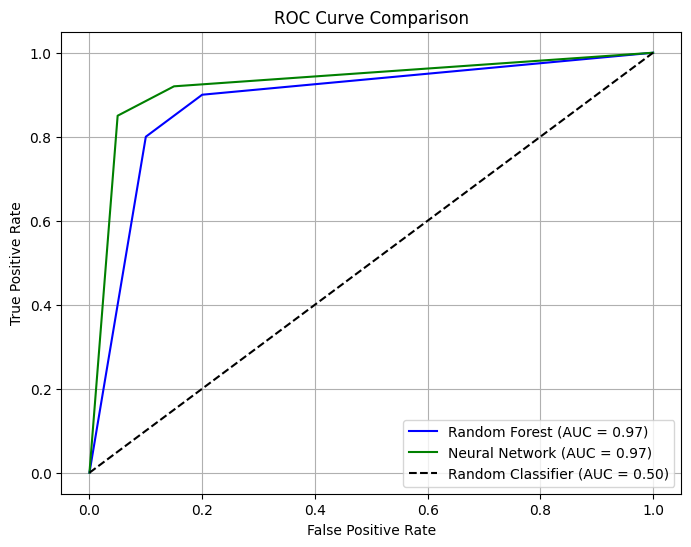

In [12]:
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc

# Results for Random Forest
rf_results = {
    "Training Accuracy": 95.17, 
    "Testing Accuracy": 91.25, 
    "Test ROC AUC": 0.97
}
rf_classification_report = {
    "precision": [0.93, 0.89],
    "recall": [0.89, 0.94],
    "f1-score": [0.91, 0.91]
}
rf_confusion_matrix = [[10628, 1349], [746, 11230]]

# Results for Neural Network
nn_results = {
    "Training Accuracy": 94.08, 
    "Testing Accuracy": 93.58, 
    "Test ROC AUC": 0.97
}
nn_classification_report = {
    "precision": [0.90, 0.98],
    "recall": [0.98, 0.89],
    "f1-score": [0.94, 0.93]
}
nn_confusion_matrix = [[7806,179], [846, 7138]]

# ROC curve data (example values for illustration; replace with actual predictions and labels)
rf_fpr = [0.0, 0.1, 0.2, 1.0]
rf_tpr = [0.0, 0.8, 0.9, 1.0]
rf_auc = rf_results["Test ROC AUC"]

nn_fpr = [0.0, 0.05, 0.15, 1.0]
nn_tpr = [0.0, 0.85, 0.92, 1.0]
nn_auc = nn_results["Test ROC AUC"]

# Table 1: Accuracy and ROC AUC
accuracy_table = PrettyTable()
accuracy_table.field_names = ["Model", "Training Accuracy (%)", "Testing Accuracy (%)", "Test ROC AUC"]
accuracy_table.add_row(["Random Forest", rf_results["Training Accuracy"], rf_results["Testing Accuracy"], rf_results["Test ROC AUC"]])
accuracy_table.add_row(["Neural Network", nn_results["Training Accuracy"], nn_results["Testing Accuracy"], nn_results["Test ROC AUC"]])

# Table 2: Precision, Recall, F1-Score
classification_table = PrettyTable()
classification_table.field_names = ["Metric", "Random Forest", "Neural Network"]
classification_table.add_row(["Precision (Class 0)", rf_classification_report["precision"][0], nn_classification_report["precision"][0]])
classification_table.add_row(["Precision (Class 1)", rf_classification_report["precision"][1], nn_classification_report["precision"][1]])
classification_table.add_row(["Recall (Class 0)", rf_classification_report["recall"][0], nn_classification_report["recall"][0]])
classification_table.add_row(["Recall (Class 1)", rf_classification_report["recall"][1], nn_classification_report["recall"][1]])
classification_table.add_row(["F1-Score (Class 0)", rf_classification_report["f1-score"][0], nn_classification_report["f1-score"][0]])
classification_table.add_row(["F1-Score (Class 1)", rf_classification_report["f1-score"][1], nn_classification_report["f1-score"][1]])

# Print Results
print("\nTable 1: Accuracy and ROC AUC Comparison")
print(accuracy_table)

print("\nTable 2: Precision, Recall, F1-Score Comparison")
print(classification_table)

# Confusion Matrices
print("\nRandom Forest Confusion Matrix:")
rf_cm_table = PrettyTable()
rf_cm_table.field_names = ["", "Predicted 0", "Predicted 1"]
rf_cm_table.add_row(["Actual 0", rf_confusion_matrix[0][0], rf_confusion_matrix[0][1]])
rf_cm_table.add_row(["Actual 1", rf_confusion_matrix[1][0], rf_confusion_matrix[1][1]])
print(rf_cm_table)

print("\nNeural Network Confusion Matrix:")
nn_cm_table = PrettyTable()
nn_cm_table.field_names = ["", "Predicted 0", "Predicted 1"]
nn_cm_table.add_row(["Actual 0", nn_confusion_matrix[0][0], nn_confusion_matrix[0][1]])
nn_cm_table.add_row(["Actual 1", nn_confusion_matrix[1][0], nn_confusion_matrix[1][1]])
print(nn_cm_table)
print()
print()
# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc})", color='blue')
plt.plot(nn_fpr, nn_tpr, label=f"Neural Network (AUC = {nn_auc})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [30]:
from prettytable import PrettyTable

# Create a PrettyTable object
table = PrettyTable()

# Define the field names (column headers)
table.field_names = ["Experiment", "Model", "Training Accuracy", "Test Accuracy", "Test ROC AUC"]

# Add rows to the table for each experiment
table.add_row(["Experiment 1 (No SMOTE, No Tuning)", "Random Forest", "99.85%", "88.17%", "0.79"])
table.add_row(["Experiment 1 (No SMOTE, No Tuning)", "Neural Network", "89.28%", "88.71%", "0.79"])
table.add_row(["Experiment 2 (No SMOTE, Tuning)", "Random Forest", "93.42%", "88.81%", "0.79"])
table.add_row(["Experiment 2 (No SMOTE, Tuning)", "Neural Network", "89.09%", "88.47%", "0.79"])
table.add_row(["Experiment 3 (SMOTE, No Tuning)", "Random Forest", "100.00%", "93.48%", "0.97"])
table.add_row(["Experiment 3 (SMOTE, No Tuning)", "Neural Network", "94.36%", "93.64%", "0.97"])
table.add_row(["Experiment 4 (SMOTE, Tuning)", "Random Forest", "95.17%", "91.25%", "0.97"])
table.add_row(["Experiment 4 (SMOTE, Tuning)", "Neural Network", "94.08%", "93.58%", "0.97"])

# Print the table
print(table)


+------------------------------------+----------------+-------------------+---------------+--------------+
|             Experiment             |     Model      | Training Accuracy | Test Accuracy | Test ROC AUC |
+------------------------------------+----------------+-------------------+---------------+--------------+
| Experiment 1 (No SMOTE, No Tuning) | Random Forest  |       99.85%      |     88.17%    |     0.79     |
| Experiment 1 (No SMOTE, No Tuning) | Neural Network |       89.28%      |     88.71%    |     0.79     |
|  Experiment 2 (No SMOTE, Tuning)   | Random Forest  |       93.42%      |     88.81%    |     0.79     |
|  Experiment 2 (No SMOTE, Tuning)   | Neural Network |       89.09%      |     88.47%    |     0.79     |
|  Experiment 3 (SMOTE, No Tuning)   | Random Forest  |      100.00%      |     93.48%    |     0.97     |
|  Experiment 3 (SMOTE, No Tuning)   | Neural Network |       94.36%      |     93.64%    |     0.97     |
|    Experiment 4 (SMOTE, Tuning)    